# Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal
import matplotlib.pyplot as plt
from pyampd.ampd import find_peaks, find_peaks_original, find_peaks_adaptive

# Loading Data

In [2]:
uni_df = pd.read_json("dataset/unified.json")
uni_df.index.name = "number"

In [3]:
uni_df.head(n = 10)

,sid,gender,age,height,weight,sbp,dbp,hr,bmi,signal
number,,,,,,,,,,
0,2,0,45,152,63,161,89,97,27.268006,"[2438.0, 2438.0, 2438.0, 2455.0, 2455.0, 2384...."
1,3,0,50,157,50,160,93,76,20.284799,"[1965.0, 1965.0, 1960.0, 1960.0, 1960.0, 1959...."
2,6,0,47,150,47,101,71,79,20.888889,"[1942.0, 1912.0, 1912.0, 1912.0, 1905.0, 1905...."
3,8,1,45,172,65,136,93,87,21.971336,"[2039.0, 2039.0, 2039.0, 2029.0, 2029.0, 2042...."
4,9,0,46,155,65,123,73,73,27.055151,"[1939.0, 1939.0, 1959.0, 1959.0, 1980.0, 1980...."
5,10,0,48,160,68,124,62,70,26.562500,"[2078.0, 2078.0, 2078.0, 2038.0, 2038.0, 2046...."
6,11,0,48,153,49,126,78,84,20.932120,"[1955.0, 1958.0, 1958.0, 1958.0, 1927.0, 1927...."
7,12,0,53,160,70,108,73,84,27.343750,"[1915.0, 1879.0, 1879.0, 1879.0, 1887.0, 1887...."
8,13,1,58,165,55,89,42,63,20.202020,"[1958.0, 1958.0, 1983.0, 1983.0, 1942.0, 1942...."


# Preprocessing Signal

## Z-score Normalized Signal

Reference: [*Estimating Blood Pressure from the Photoplethysmogram Signal and Demographic Features Using Machine Learning Techniques*](https://doi.org/10.3390/s20113127)

In [4]:
# sid = 58
# raw = uni_df.loc[uni_df["sid"] == sid]["signal"].item()
index = 179
information = uni_df.loc[index]
raw = information["signal"]
sid = information["sid"].item()
normalized = (np.array(raw) - np.mean(raw)) / np.std(raw)

### Visualization

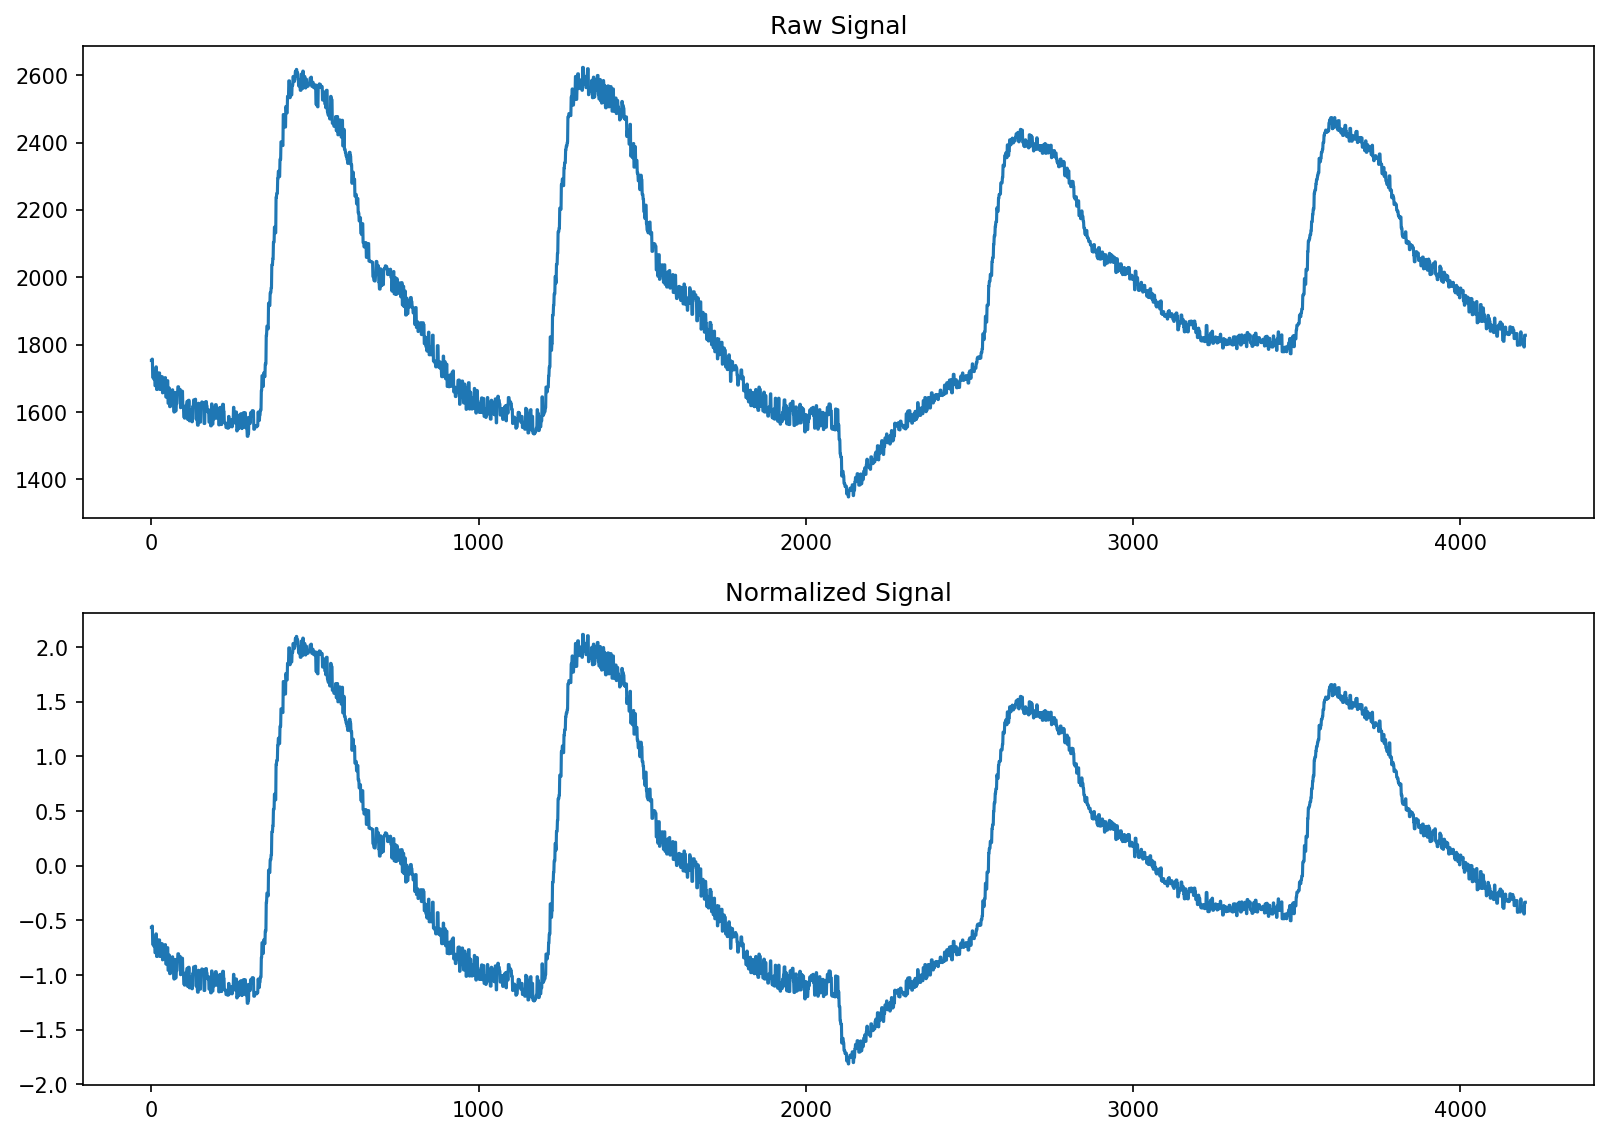

In [5]:
fig, axs = plt.subplots(2, 1, dpi = 150)

axs[0].plot(raw)
axs[0].set_title("Raw Signal")

axs[1].plot(normalized)
axs[1].set_title("Normalized Signal")

fig.set_figwidth(13)
fig.set_figheight(9)

plt.show()

## Signal Filteration

Reference: *Butterworth infinite impulse response (IIR) zero-phase filter* from [*Estimating Blood Pressure from the Photoplethysmogram Signal and Demographic Features Using Machine Learning Techniques*](https://doi.org/10.3390/s20113127).

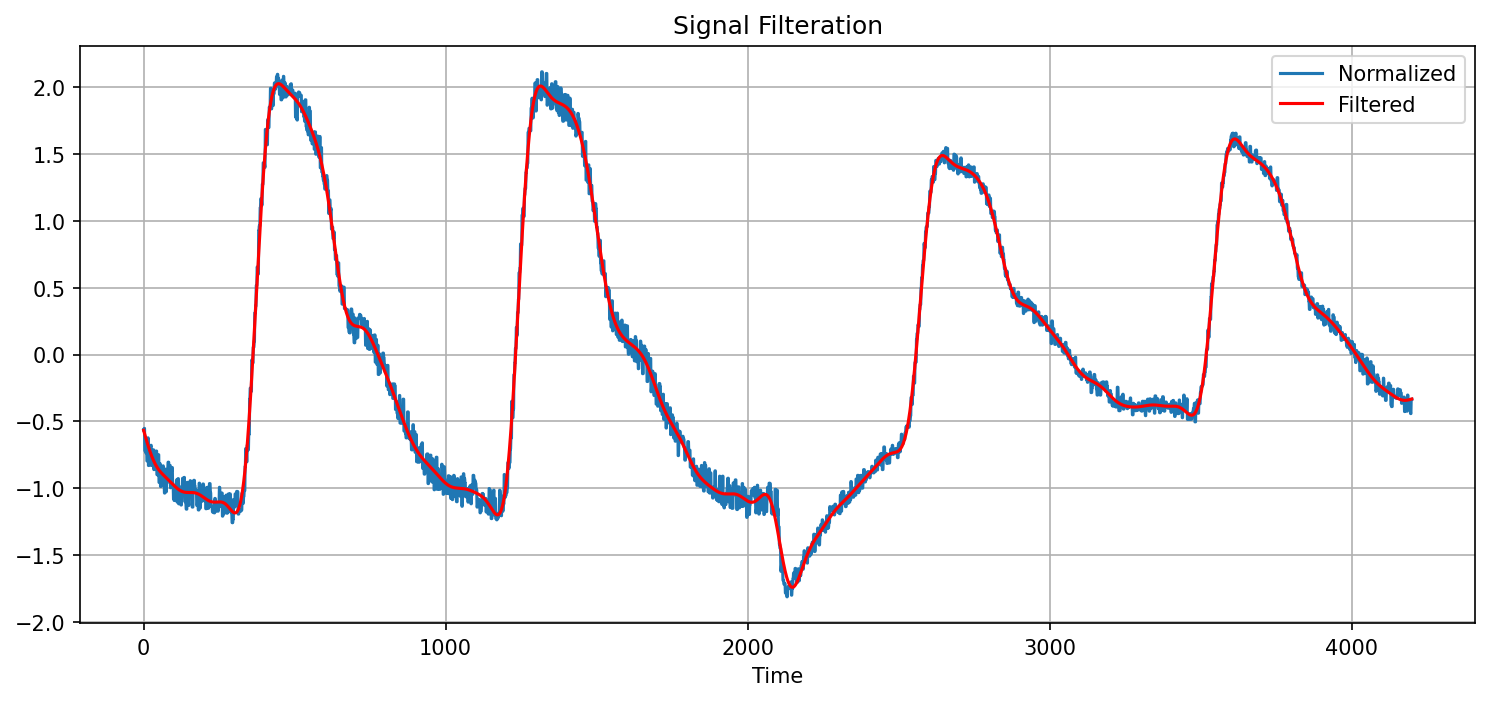

In [6]:
plt.figure(figsize = (12, 5), dpi = 150)
plt.plot(normalized)

# b, a = signal.butter(6, 0.025)
b, a = signal.butter(6, 0.02)
filtered = signal.filtfilt(b, a, normalized, padlen = 150)

# b, a = signal.butter(6, 0.020)
# filtered = signal.filtfilt(b, a, filtered, padlen = 150)

plt.plot(filtered, color = "red")
plt.grid()
plt.title("Signal Filteration")
plt.xlabel("Time")
plt.legend(["Normalized", "Filtered"])
plt.show()

## Baseline Correction

Reference: [*Estimating Blood Pressure from the Photoplethysmogram Signal and Demographic Features Using Machine Learning Techniques*](https://doi.org/10.3390/s20113127).

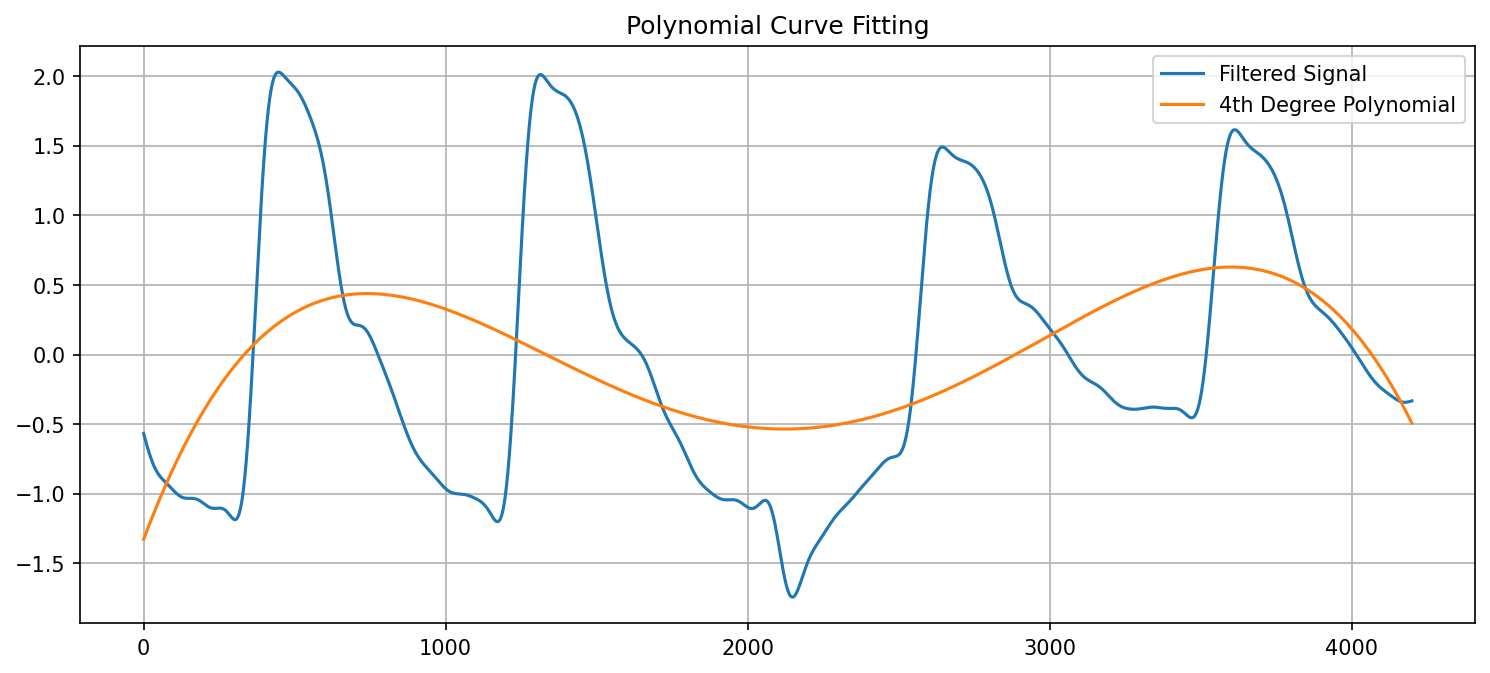

In [7]:
x = np.arange(filtered.shape[0])
model = np.poly1d(np.polyfit(x, filtered, 4))
curve = model(x)
plt.figure(figsize = (12, 5), dpi = 150)
plt.plot(filtered)
plt.plot(curve)
plt.title("Polynomial Curve Fitting")
plt.legend(["Filtered Signal", "4th Degree Polynomial"])
plt.grid()
plt.show()

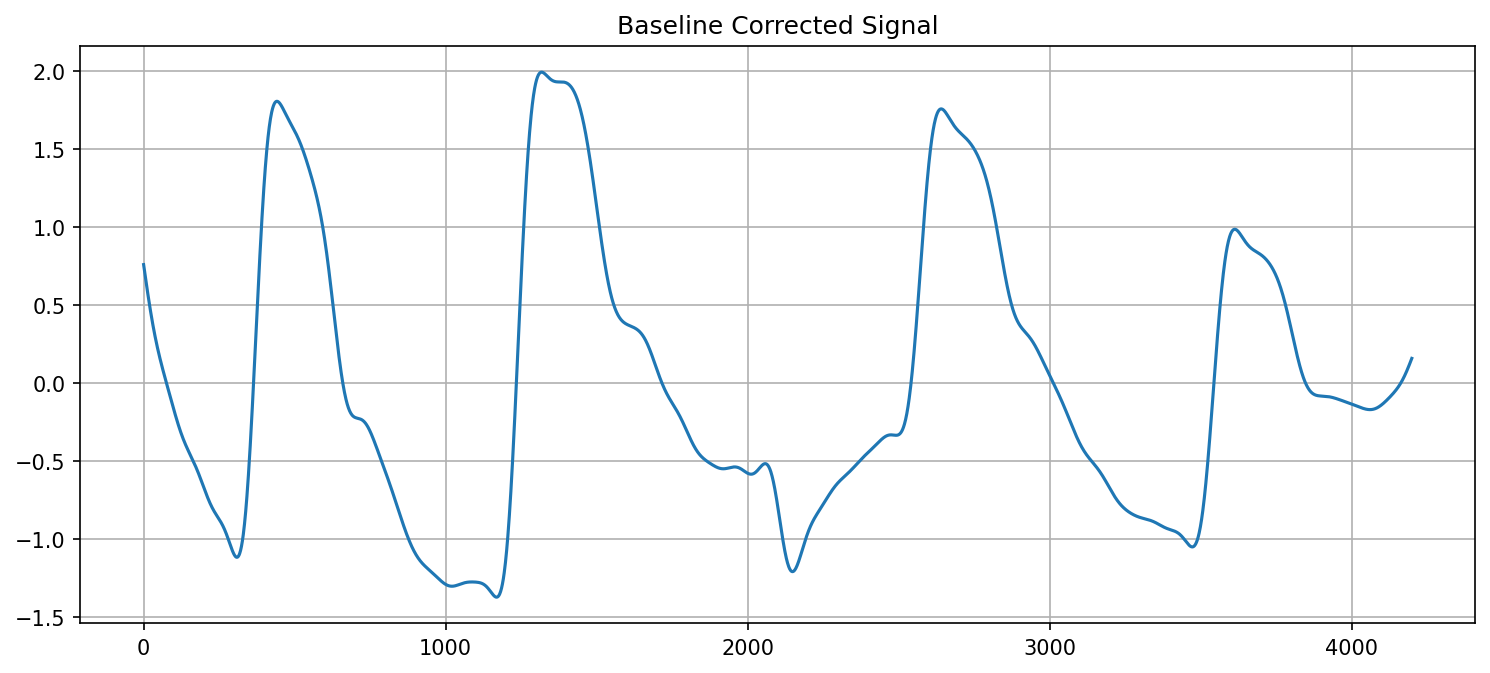

In [8]:
filtered = filtered - curve
plt.figure(figsize = (12, 5), dpi = 150)
plt.plot(filtered)
plt.title("Baseline Corrected Signal")
plt.grid()
plt.show()

## Derivatives and Key Points Detection

References:
1. [Blood Pressure Estimation Using Photoplethysmogram Signal and Its Morphological Features](https://doi.org/10.1109/JSEN.2019.2961411)
2. [Estimating Blood Pressure from the Photoplethysmogram Signal and Demographic Features Using Machine Learning Techniques](https://doi.org/10.3390/s20113127)

### Derivatives

In [9]:
grad = np.gradient(filtered)
grad = (np.array(grad) - np.mean(grad)) / np.std(grad)

gradgrad = np.gradient(grad)
gradgrad = (np.array(gradgrad) - np.mean(gradgrad)) / np.std(gradgrad)

### Detection of Maximum and Minimum Points using AMPD Algorithm

Reference: [Blood Pressure Estimation Using Photoplethysmogram Signal and Its Morphological Features](https://doi.org/10.1109/JSEN.2019.2961411)

Automatic Multiscale-based Peak Detection (AMPD):

1. https://github.com/ig248/pyampd
2. https://doi.org/10.1109/ICRERA.2016.7884365

`find_peaks` has the functionality different than what is proposed on original paper. Use `find_peaks_original` instead.

In [10]:
peaks = find_peaks(filtered)
throughs = find_peaks(np.negative(filtered))

# gradx = np.copy(grad)
# gradx[gradx < 0] = 0
# peaks, _ = signal.find_peaks(gradx)

# gradx = np.copy(grad)
# gradx[gradx > 0] = 0
# g_local_maxs = list(peaks)
# throughs,_ = signal.find_peaks(np.negative(gradx))
# g_local_mins = list(throughs)

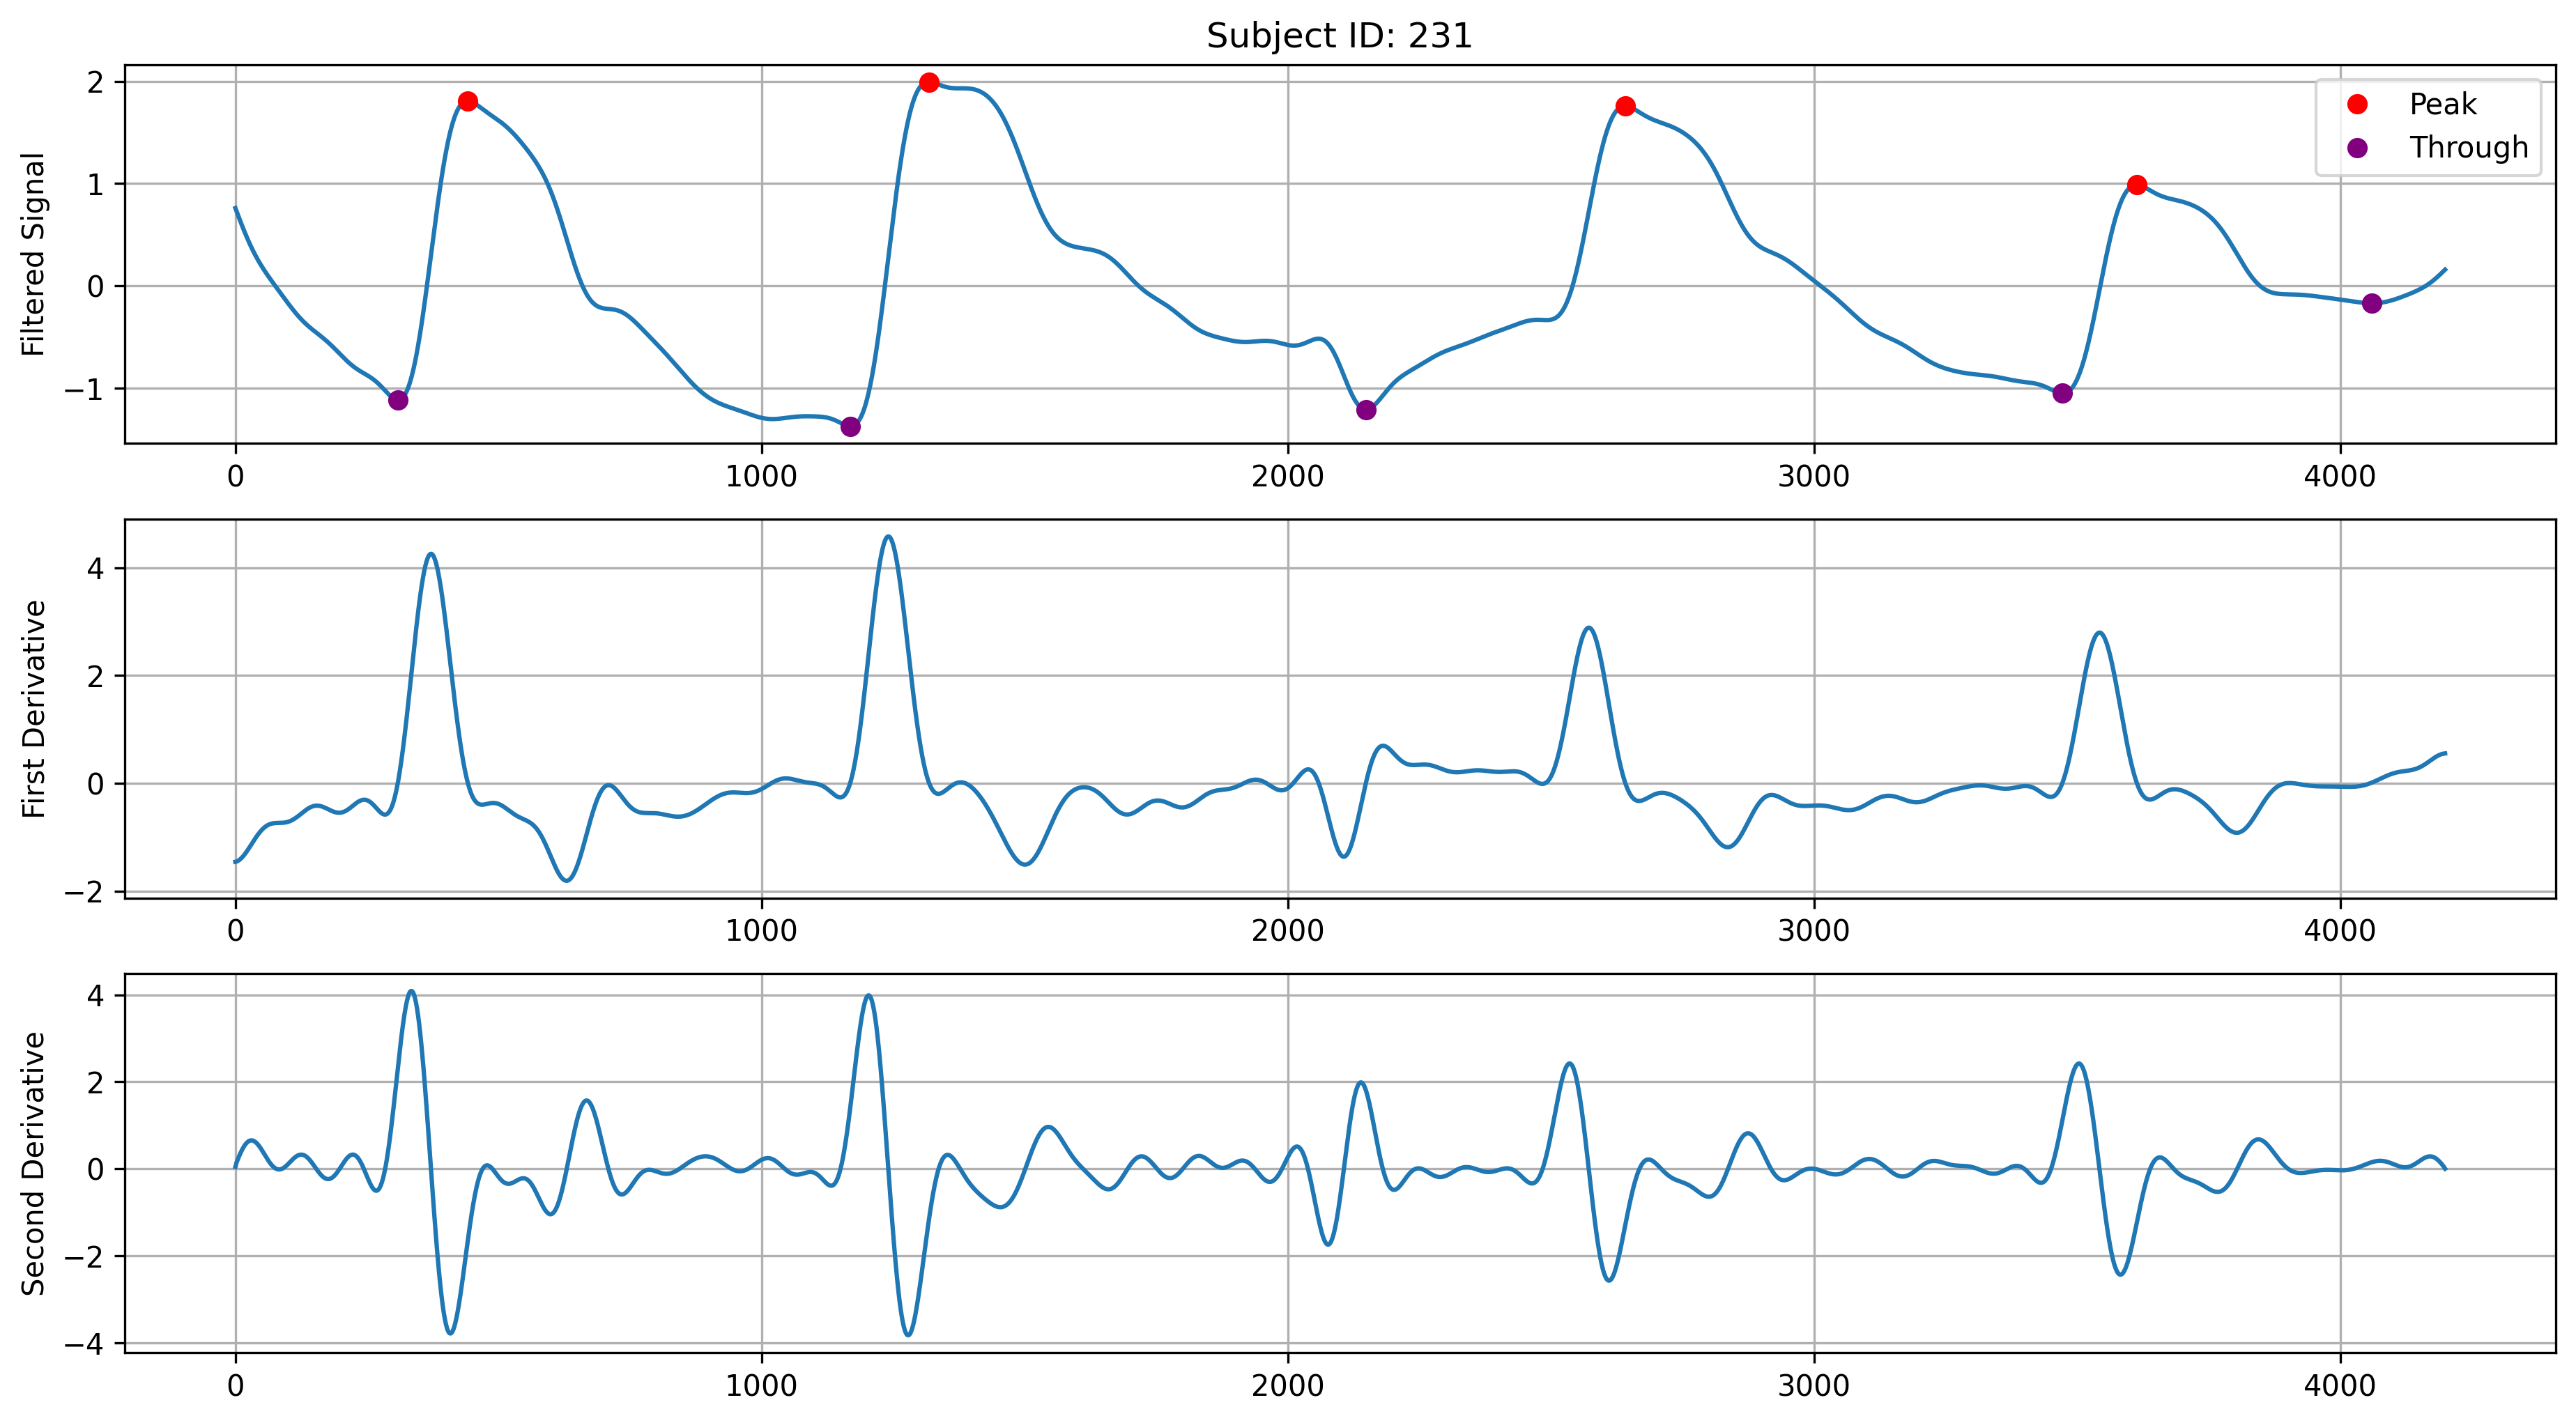

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 8), dpi = 300)

ax1.plot(filtered)
ax1.plot(peaks, filtered[peaks], "o", color = "red", label = "Peak")
ax1.plot(throughs, filtered[throughs], "o", color = "purple", label = "Through")
ax1.legend()
ax1.grid()
ax1.set_ylabel("Filtered Signal")

ax2.plot(grad)
ax2.grid()
ax2.set_ylabel("First Derivative")

ax3.plot(gradgrad)
ax3.grid()
ax3.set_ylabel("Second Derivative")

ax1.set_title(f"Subject ID: {sid}")
plt.show()

### Ascending and Descending Sections and Detection of Foots and Systolic Peaks

Reference: [Blood Pressure Estimation Using Photoplethysmogram Signal and Its Morphological Features](https://doi.org/10.1109/JSEN.2019.2961411)

In [12]:
ascending_sections = []
descending_sections = []

systolic_peaks = [x for x in peaks if x != 0 and x != len(filtered) - 1]

foots = set()

for i in range(1, len(throughs)):
    ta, tb = throughs[i - 1], throughs[i]
    
    if ta == 0 or tb == 0 or ta == len(filtered) - 1 or tb == len(filtered) - 1:
        continue
        
    peak = 0
    for y in peaks:
        if ta < y < tb:
            peak = y
            break

    if not peak:
        continue
    
    ascending_section = throughs[i - 1], peak
    descending_section = peak, throughs[i]

    ascending_sections.append(ascending_section)
    descending_sections.append(descending_section)

    foots.add(throughs[i - 1])
    foots.add(throughs[i])

foots = sorted(list(foots))

In [13]:
ascending_sections, descending_sections

([(309, 441), (1169, 1318), (2148, 2641), (3472, 3613)],
 [(441, 1169), (1318, 2148), (2641, 3472), (3613, 4060)])

### Detection of Maximum Slope Points

Reference: [Blood Pressure Estimation Using Photoplethysmogram Signal and Its Morphological Features](https://doi.org/10.1109/JSEN.2019.2961411)

In [14]:
max_slope_points = [
    np.argmax(grad[a:b]) + a
    for a, b in ascending_sections
]

### Detection of Diastolic Peaks

Reference: [Blood Pressure Estimation Using Photoplethysmogram Signal and Its Morphological Features](https://doi.org/10.1109/JSEN.2019.2961411)

In [15]:
diastolic_peaks = []

for a, b in descending_sections:
    diastolic_peak = -1

    candidates, _ = signal.find_peaks(filtered[a:b])
    candidates = np.array(candidates) + a    

    for candidate in candidates.tolist():
        if candidate != a and gradgrad[candidate] < 0:
            diastolic_peak = candidate
            break

    if diastolic_peak != -1:
        diastolic_peaks.append(diastolic_peak)
    else:
        gg_local_mins = find_peaks(np.negative(gradgrad[a:b]))

        threshold = 10
        gg_local_mins = [x for x in gg_local_mins if threshold < x < b - a - threshold]

        diastolic_peak = gg_local_mins[-1] + a
        diastolic_peaks.append(diastolic_peak)

### Detection of Dicrotic Notchs

Reference: [Estimating Blood Pressure from the Photoplethysmogram Signal and Demographic Features Using Machine Learning Techniques](https://doi.org/10.3390/s20113127)

In [16]:
notchs = []

for i, (a, b) in enumerate(descending_sections):
    s, e = a, diastolic_peaks[i]

    slope = (filtered[e] - filtered[s]) / (e - s)
    h = filtered[s] - slope * s
    xs = np.arange(s, e)
    line = slope * xs + h

    notch = np.argmin(filtered[s:e] - line) + s

    WINDOW = 25

    candidates, _ = signal.find_peaks(np.negative(filtered[a:b]))
    candidates = np.array(candidates) + a

    for candidate in candidates:
        if notch - WINDOW <= candidate <= notch + WINDOW:
            notch = candidate
            break
    
    notchs.append(notch)

### Detection of Inflection Point

Reference: [Blood Pressure Estimation Using Photoplethysmogram Signal and Its Morphological Features](https://doi.org/10.1109/JSEN.2019.2961411)

In [17]:
inflections = []

for i, v in enumerate(notchs):
    a, b = v, diastolic_peaks[i]
    candidates = find_peaks_original(grad)
    candidates = [candidate for candidate in candidates if a < candidate < b]
    if candidates:
        inflections.append(candidates[int(len(candidates) / 2)])
    else:
        inflections.append(int((a + b) / 2))

### Visualization

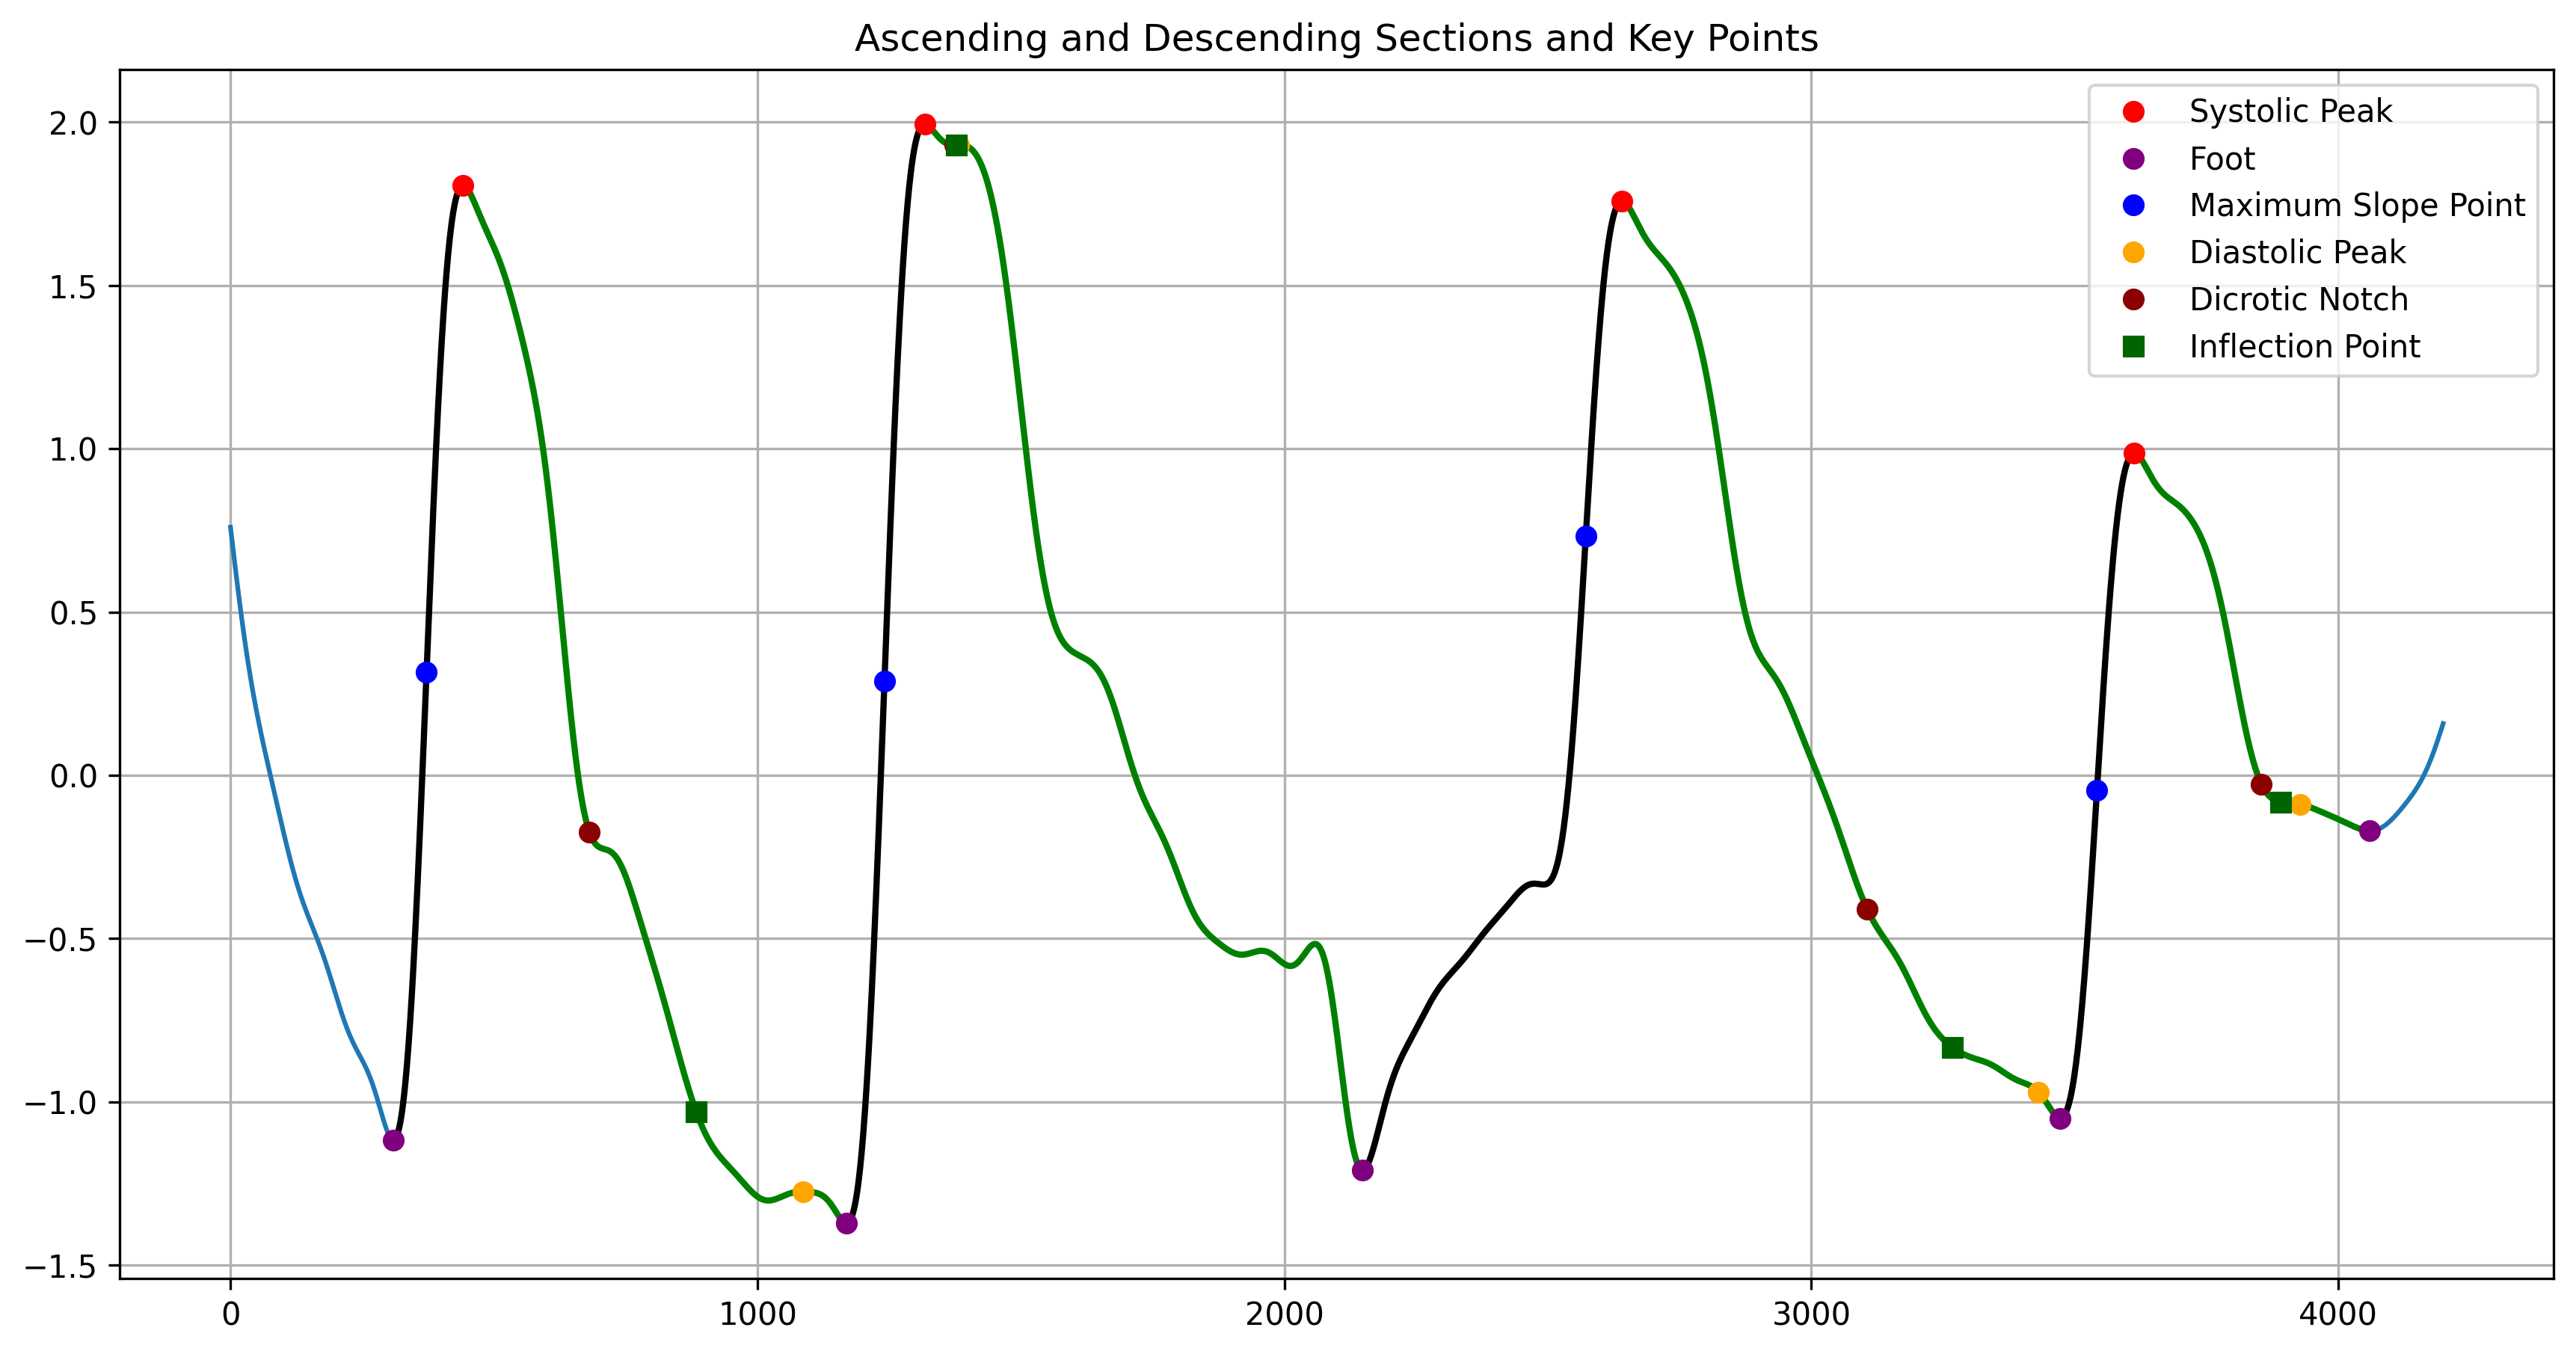

In [18]:
plt.figure(figsize = (14, 7), dpi = 300)
plt.plot(filtered)
for a, b in ascending_sections:
    plt.plot(np.arange(a, b), filtered[a:b], linestyle = "-", linewidth = 2, color = "black")
for a, b in descending_sections:
    x = np.arange(a, b)
    plt.plot(np.arange(a, b), filtered[a:b], linestyle = "-", linewidth = 2, color = "green")
plt.plot(systolic_peaks, filtered[systolic_peaks], "o", color = "red", label = "Systolic Peak")
plt.plot(foots, filtered[foots], "o", color = "purple", label = "Foot")
plt.plot(max_slope_points, filtered[max_slope_points], "o", color = "blue", label = "Maximum Slope Point")
plt.plot(diastolic_peaks, filtered[diastolic_peaks], "o", color = "orange", label = "Diastolic Peak")
plt.plot(notchs, filtered[notchs], "o", color = "darkred", label = "Dicrotic Notch")
plt.plot(inflections, filtered[inflections], "s", color = "darkgreen", label = "Inflection Point")
plt.title("Ascending and Descending Sections and Key Points")
plt.legend()
plt.grid()
plt.show()

## Feature Extraction

References:

1. Blood Pressure Estimation Using Photoplethysmogram Signal and Its Morphological Features
2. Continuous and Noninvasive Estimation of Arterial Blood Pressure Using a Photoplethysmographic Approach
3. Enhancement of blood pressure estimation method via machine learning
4. **Estimating Blood Pressure from the Photoplethysmogram Signal and Demographic Features Using Machine Learning Techniques**
5. Recurrent Neural Network Models for Blood Pressure Monitoring Using PPG Morphological Features

In [19]:
features = {}

### Systolic Peak (x)

In [20]:
features["x"] = filtered[systolic_peaks[0]] - filtered[foots[0]]
features["x"]

2.9230285867968258

### Diastolic Peak (y)

In [21]:
e, s = foots[1], foots[0]
slope = (filtered[e] - filtered[s]) / (e - s)
h = filtered[s] - slope * s
xs = np.arange(s, e)
line = slope * xs + h

features["y"] = filtered[diastolic_peaks[0]] - line[diastolic_peaks[0] - s]
features["y"]

0.07316652846084226

### Height of Notch (z)

In [22]:
features["z"] = filtered[notchs[0]] - line[notchs[0] - s]
features["z"]

1.053829318258516

### Systolic Peak Time (t1)

In [23]:
features["t1"] =  systolic_peaks[0] - foots[0]
features["t1"]

132

### Diastolic Peak Time (t2)

In [24]:
features["t2"] =  diastolic_peaks[0] - foots[0]
features["t2"]

778

### Height of Notch Time (t3)

In [25]:
features["t3"] =  notchs[0] - foots[0]
features["t3"]

372

### ΔT

In [26]:
features["delta_t"] =  features["t2"] - features["t1"]
features["delta_t"]

646

### Pulse Interval (tpi)

In [27]:
features["tpi"] =  foots[1] - foots[0]
features["tpi"]

860

### Peak-to-Peak Interval (tpp)

In [28]:
features["tpp"] =  systolic_peaks[1] - systolic_peaks[0]
features["tpp"]

877

### Pulse Width

In [29]:
def crossing_value (array, value):
    indices = set()
    for i in range(len(array) - 1):
        if array[i] == value:
            indices.add(i)
        elif (array[i] - value) * (array[i + 1] - value) < 0:
            indices.add(i + 0.5)
    return np.array(sorted(list(indices)))

In [30]:
half_height = features["x"] / 2 + filtered[foots[0]]
indices = crossing_value(filtered, half_height)
features["pulse_width"] = int(indices[1] - indices[0])
features["pulse_width"]

339

### Inflection Point Area

### Augmentation Index (y/x)

In [31]:
features["y/x"] = features["y"] / features["x"]
features["y/x"]

0.025031068389591474

### Alternative Augmentation Index ((x-y)/x)

In [32]:
features["(x-y)/x"] = (features["x"] - features["y"]) / features["x"]
features["(x-y)/x"]

0.9749689316104085

### Systolic Peak Output Curve (t1/x)

In [33]:
features["t1/x"] = features["t1"] / features["x"]
features["t1/x"]

45.158641484464916

### Diastolic Peak Downward Curve (y/(tpi-t3))

In [34]:
features["y/(tpi-t3)"] = features["x"] / (features["tpi"] - features["t3"])
features["y/(tpi-t3)"]

0.005989812677862348

### t1/tpp

In [35]:
features["t1/tpp"] = features["t1"] / features["tpp"]
features["t1/tpp"]

0.15051311288483465

### t2/tpp

In [36]:
features["t2/tpp"] = features["t2"] / features["tpp"]
features["t2/tpp"]

0.887115165336374

### t3/tpp

In [37]:
features["t3/tpp"] = features["t3"] / features["tpp"]
features["t3/tpp"]

0.4241733181299886

### ΔT/tpp

In [38]:
features["delta_t/tpp"] = features["delta_t"] / features["tpp"]
features["delta_t/tpp"]

0.7366020524515393

### z/x

In [39]:
features["z/x"] = features["z"] / features["x"]
features["z/x"]

0.36052651794738183

### t2/z

In [40]:
features["t2/z"] = features["t2"] / features["z"]
features["t2/z"]

738.2599691624332

### t3/y

In [41]:
features["t3/y"] = features["t3"] / features["y"]
features["t3/y"]

5084.2920639468275

### x/(tpi-t1)

In [42]:
features["x/(tpi-t1)"] = features["x"] / (features["tpi"] - features["t1"])
features["x/(tpi-t1)"]

0.004015149157687948

### z/(tpi-t2)

In [43]:
features["z/(tpi-t2)"] = features["z"] / (features["tpi"] - features["t2"])
features["z/(tpi-t2)"]

0.01285157705193312

### Width-related Features

In [44]:
for w in [25, 50, 75]:
    candidates = crossing_value(filtered, filtered[foots[0]] + (w / 100) * features["x"])
    candidates = [candidate for candidate in candidates if foots[0] < candidate < foots[1]]
    features[f"width{w}"] = candidates[-1] - candidates[0]
    features[f"width{w}/t1"] = features[f"width{w}"] / features["t1"]
    features[f"width{w}/t2"] = features[f"width{w}"] / features["t2"]
    features[f"width{w}/t3"] = features[f"width{w}"] / features["t3"]
    features[f"width{w}/delta_t"] = features[f"width{w}"] / features["delta_t"]
    features[f"width{w}/tpi"] = features[f"width{w}"] / features["tpi"]

### Derivative-related Features

In [45]:
grad_peaks = find_peaks(grad)
a1 = 0
for peak in grad_peaks:
    if foots[0] < peak < foots[1]:
        a1 = peak
        break

In [46]:
gradgrad_peaks = find_peaks(gradgrad)
a2 = 0
for peak in gradgrad_peaks:
    if peak > a1:
        a2 = peak
        break

In [47]:
grad_throughs = find_peaks(np.negative(grad))
b1 = 0
for through in grad_throughs:
    if through > a1:
        b1 = through
        break

In [48]:
gradgrad_throughs = find_peaks(np.negative(gradgrad))
b2 = 0
for through in gradgrad_throughs:
    if through > a2:
        b2 = through
        break

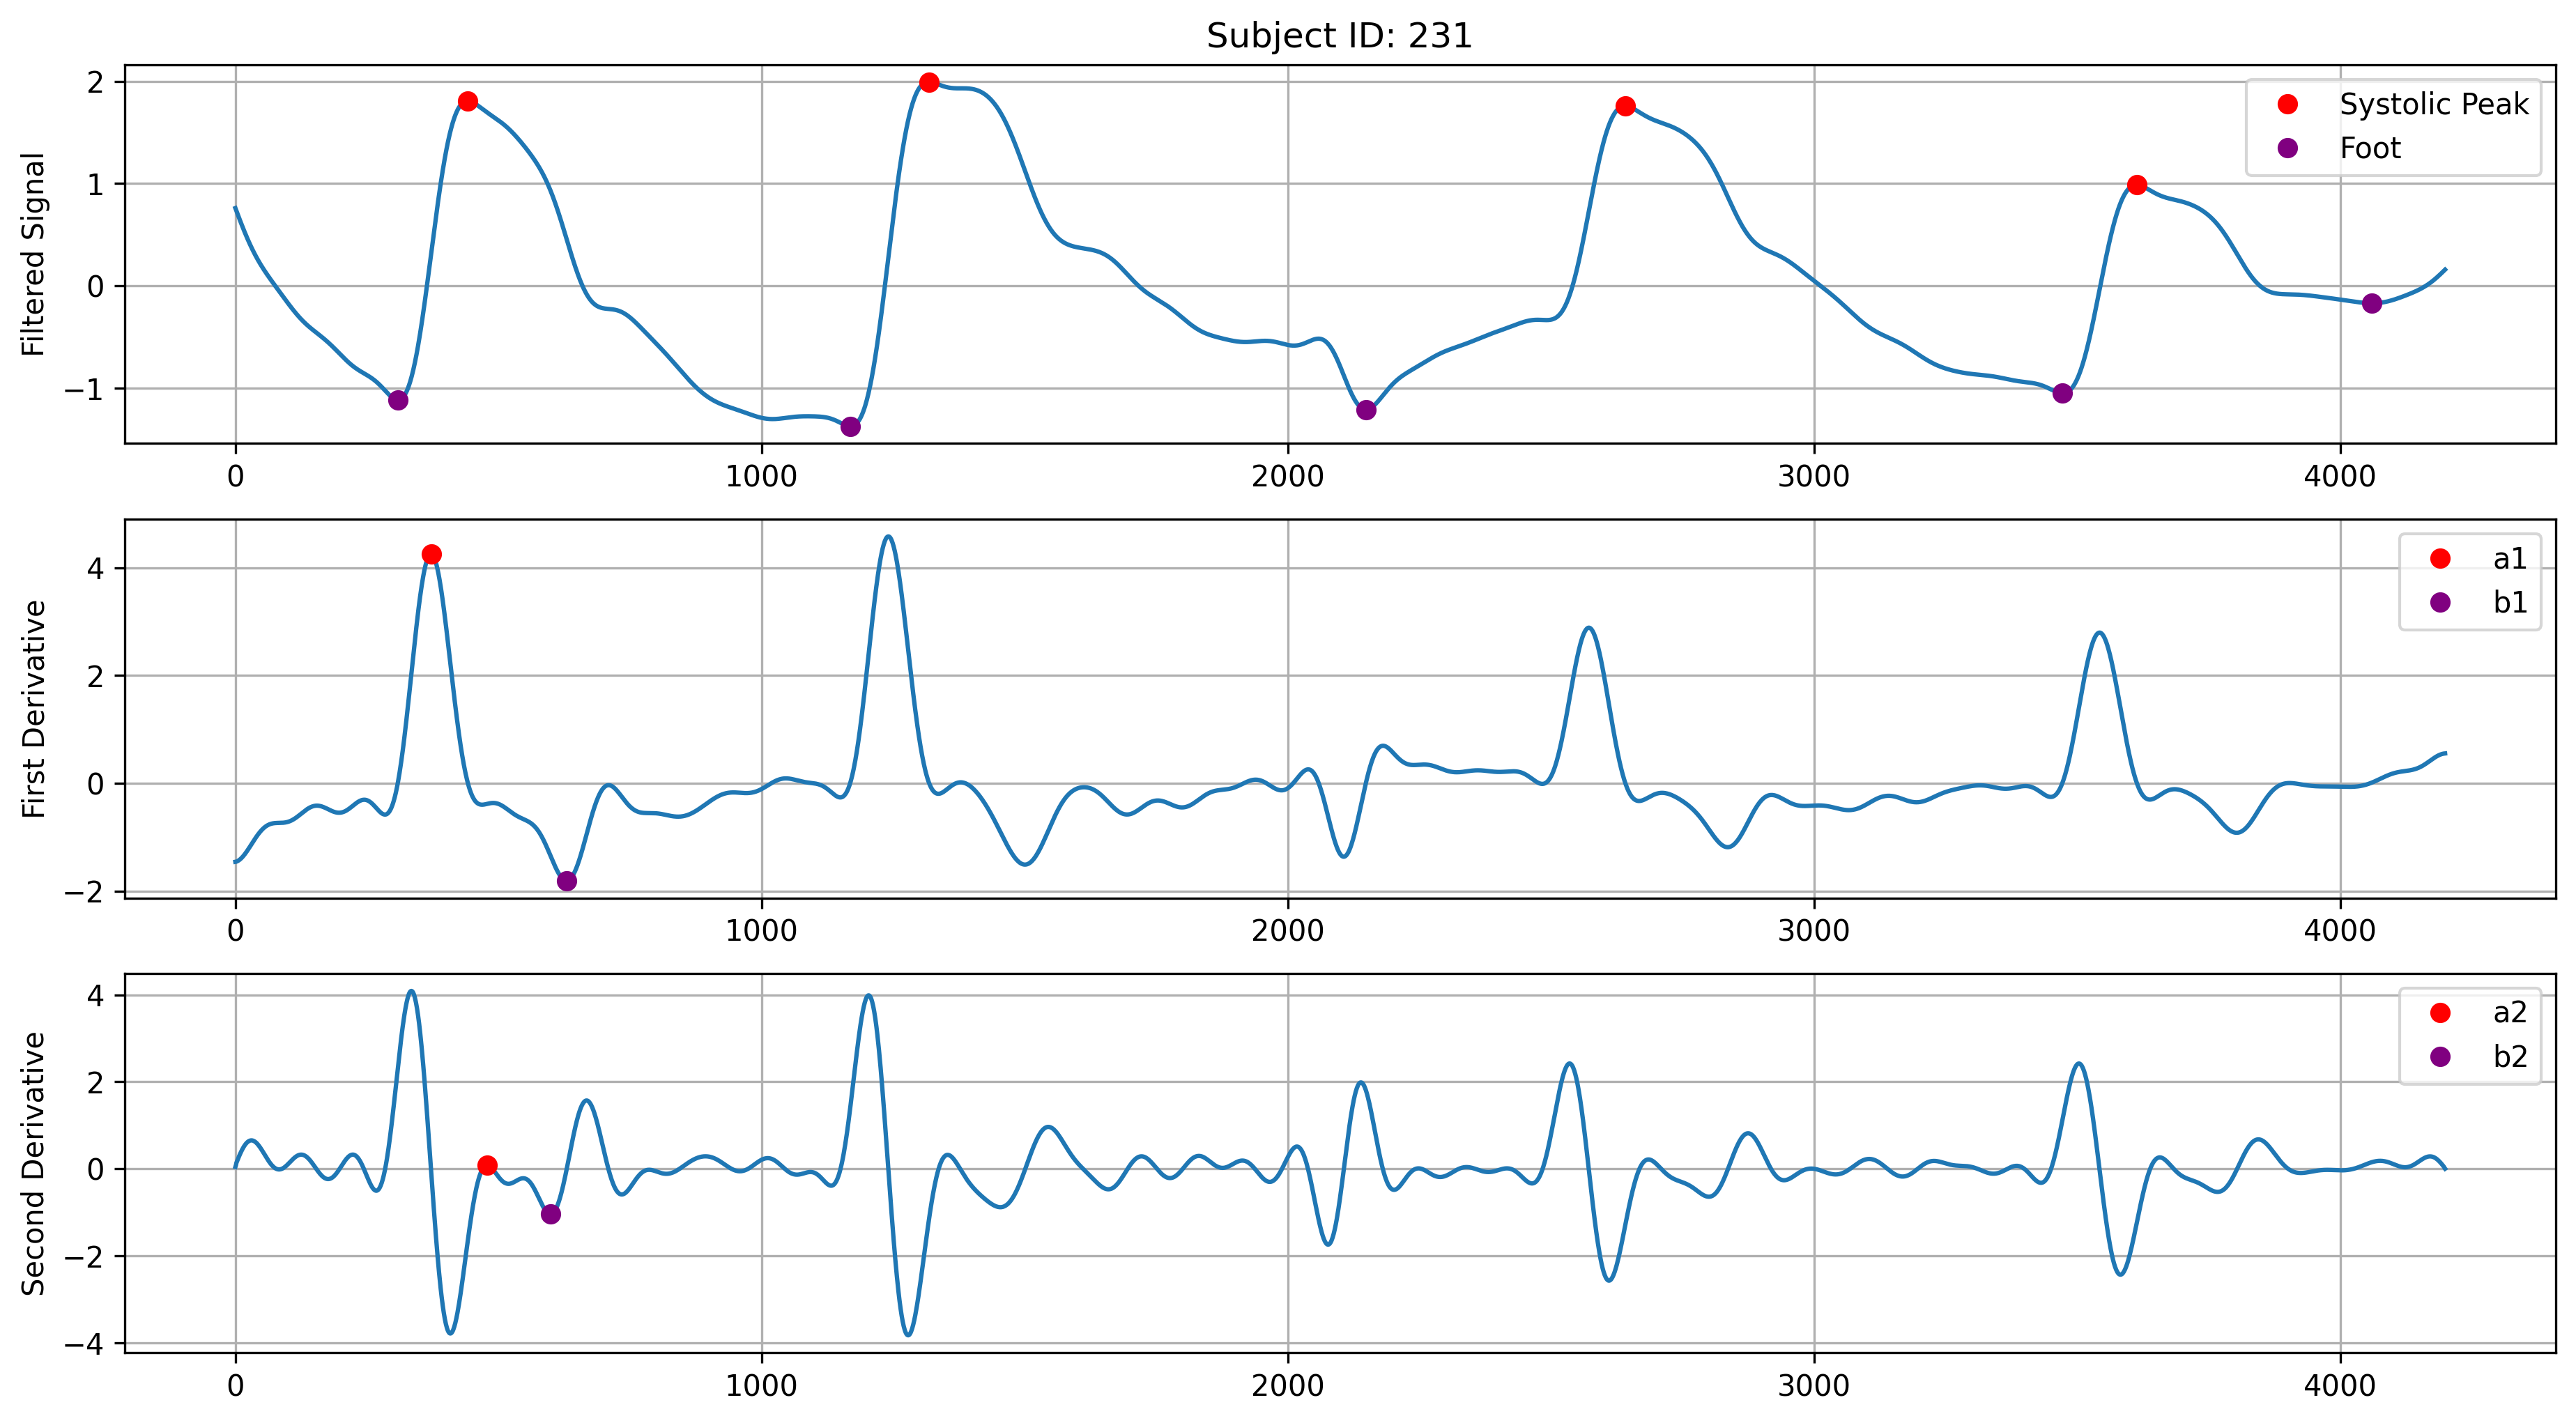

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 8), dpi = 300)

ax1.plot(filtered)
ax1.plot(systolic_peaks, filtered[systolic_peaks], "o", color = "red", label = "Systolic Peak")
ax1.plot(foots, filtered[foots], "o", color = "purple", label = "Foot")
ax1.legend()
ax1.grid()
ax1.set_ylabel("Filtered Signal")

ax2.plot(grad)
ax2.plot(a1, grad[a1], "o", color = "red", label = "a1")
ax2.plot(b1, grad[b1], "o", color = "purple", label = "b1")
ax2.legend()
ax2.grid()
ax2.set_ylabel("First Derivative")

ax3.plot(gradgrad)
ax3.plot(a2, gradgrad[a2], "o", color = "red", label = "a2")
ax3.plot(b2, gradgrad[b2], "o", color = "purple", label = "b2")

ax3.legend()
ax3.grid()
ax3.set_ylabel("Second Derivative")

ax1.set_title(f"Subject ID: {sid}")
plt.show()

In [50]:
features["a1"] = a1
features["ta1"] = a1 - foots[0]
features["a2"] = a2
features["ta2"] = a2 - foots[0]
features["b1"] = b1
features["tb1"] = b1 - foots[0]
features["b2"] = b2
features["tb2"] = b2 - foots[0]

In [51]:
features["b2/a2"] = features["b2"] / features["a2"]
features["b1/a1"] = features["b1"] / features["a1"]
features["ta1/tpp"] = features["ta1"] / features["tpp"]
features["tb1/tpp"] = features["tb1"] / features["tpp"]
features["tb2/tpp"] = features["tb2"] / features["tpp"]
features["ta2/tpp"] = features["ta2"] / features["tpp"]
features["(ta1-ta2)/tpp"] = (features["ta1"] - features["ta2"]) / features["tpp"]
features["(tb1-tb2)/tpp"] = (features["tb1"] - features["tb2"]) / features["tpp"]

### Demographic Time-Domain Features

In [52]:
for feature in ["delta_t", "t1", "t2", "t3", "tpi", "tpp"]:
    features[f"height/{feature}"] = information["height"] / features[feature]
    features[f"weight/{feature}"] = information["weight"] / features[feature]
    features[f"bmi/{feature}"] = information["bmi"] / features[feature]

### Statistical Features

### Overview of Features

In [53]:
features

{'x': 2.9230285867968258,
 'y': 0.07316652846084226,
 'z': 1.053829318258516,
 't1': 132,
 't2': 778,
 't3': 372,
 'delta_t': 646,
 'tpi': 860,
 'tpp': 877,
 'pulse_width': 339,
 'y/x': 0.025031068389591474,
 '(x-y)/x': 0.9749689316104085,
 't1/x': 45.158641484464916,
 'y/(tpi-t3)': 0.005989812677862348,
 't1/tpp': 0.15051311288483465,
 't2/tpp': 0.887115165336374,
 't3/tpp': 0.4241733181299886,
 'delta_t/tpp': 0.7366020524515393,
 'z/x': 0.36052651794738183,
 't2/z': 738.2599691624332,
 't3/y': 5084.2920639468275,
 'x/(tpi-t1)': 0.004015149157687948,
 'z/(tpi-t2)': 0.01285157705193312,
 'width25': 413.0,
 'width25/t1': 3.128787878787879,
 'width25/t2': 0.5308483290488432,
 'width25/t3': 1.1102150537634408,
 'width25/delta_t': 0.6393188854489165,
 'width25/tpi': 0.48023255813953486,
 'width50': 264.0,
 'width50/t1': 2.0,
 'width50/t2': 0.3393316195372751,
 'width50/t3': 0.7096774193548387,
 'width50/delta_t': 0.4086687306501548,
 'width50/tpi': 0.30697674418604654,
 'width75': 194.0,
 

In [54]:
len(features)

75